In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sicapv2/SICAPv2_Kaggle/Val/Images/18771.jpg
/kaggle/input/sicapv2/SICAPv2_Kaggle/Val/Images/18775.jpg
/kaggle/input/sicapv2/SICAPv2_Kaggle/Val/Images/18765.jpg
/kaggle/input/sicapv2/SICAPv2_Kaggle/Val/Images/18773.jpg
/kaggle/input/sicapv2/SICAPv2_Kaggle/Val/Images/18781.jpg
/kaggle/input/sicapv2/SICAPv2_Kaggle/Val/Images/18770.jpg
/kaggle/input/sicapv2/SICAPv2_Kaggle/Val/Images/18769.jpg
/kaggle/input/sicapv2/SICAPv2_Kaggle/Val/Images/18780.jpg
/kaggle/input/sicapv2/SICAPv2_Kaggle/Val/Images/18774.jpg
/kaggle/input/sicapv2/SICAPv2_Kaggle/Val/Images/18772.jpg
/kaggle/input/sicapv2/SICAPv2_Kaggle/Val/Images/18767.jpg
/kaggle/input/sicapv2/SICAPv2_Kaggle/Val/Images/18782.jpg
/kaggle/input/sicapv2/SICAPv2_Kaggle/Val/Images/18779.jpg
/kaggle/input/sicapv2/SICAPv2_Kaggle/Val/Images/18766.jpg
/kaggle/input/sicapv2/SICAPv2_Kaggle/Val/Images/18776.jpg
/kaggle/input/sicapv2/SICAPv2_Kaggle/Val/Images/18778.jpg
/kaggle/input/sicapv2/SICAPv2_Kaggle/Val/Images/18768.jpg
/kaggle/input/

In [2]:
# Install Packages
!pip install torch torchvision --index-url https://download.pytorch.org/whl/cu121 
!pip install segmentation-models-pytorch albumentations opencv-python pandas matplotlib tqdm

Looking in indexes: https://download.pytorch.org/whl/cu121
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.5/780.5 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 79.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 48.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 91.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 8.8 MB/s e

In [3]:
# Imports and configuration

import os, glob, cv2, numpy as np, pandas as pd, matplotlib.pyplot as plt, torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp
from tqdm import tqdm
import random

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)

set_seed(42)


# Paths
TRAIN_IMAGE_DIR = "/kaggle/input/sicapv2/SICAPv2_Kaggle/Train/Images"
TRAIN_MASK_DIR  = "/kaggle/input/sicapv2/SICAPv2_Kaggle/Train/Masks"
VAL_IMAGE_DIR   = "/kaggle/input/sicapv2/SICAPv2_Kaggle/Val/Images"
VAL_MASK_DIR    = "/kaggle/input/sicapv2/SICAPv2_Kaggle/Val/Masks"

IMG_EXTS = (".png",".jpg",".jpeg",".tif",".tiff",".bmp")
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
OUT_DIR = "unet_results"; os.makedirs(OUT_DIR, exist_ok=True)

In [4]:
# Dataset and transforms

def list_images(d, exts=IMG_EXTS):
    paths=[]
    for e in exts: paths += glob.glob(os.path.join(d, f"*{e}"))
    return sorted(paths)

def mask_for(img_path, mask_dir):
    base = os.path.splitext(os.path.basename(img_path))[0]
    for e in IMG_EXTS:
        p = os.path.join(mask_dir, base+e)
        if os.path.exists(p): return p
    return None

class SicapDataset(Dataset):
    def __init__(self, img_dir, mask_dir, aug=None):
        self.imgs = list_images(img_dir)
        self.mask_dir = mask_dir
        self.aug = aug
        # drop any without masks
        self.pairs = [(p, mask_for(p, mask_dir)) for p in self.imgs]
        self.pairs = [(i,m) for (i,m) in self.pairs if m is not None]
    def __len__(self): return len(self.pairs)
    def __getitem__(self, idx):
        ip, mp = self.pairs[idx]
        img = cv2.cvtColor(cv2.imread(ip, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mp, cv2.IMREAD_GRAYSCALE)
        # binarize robustly
        _, mask = cv2.threshold(mask, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
        mask = (mask>0).astype(np.uint8)
        if self.aug:
            out = self.aug(image=img, mask=mask)
            img, mask = out["image"], out["mask"]
        return img.float()/255.0, mask.unsqueeze(0).float()  # CxHxW

# 512x512, light aug;
train_tf = A.Compose([
    A.LongestMaxSize(512), A.PadIfNeeded(512,512, border_mode=cv2.BORDER_REFLECT),
    A.HorizontalFlip(p=0.5), A.VerticalFlip(p=0.5), A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(0.1, 0.1, p=0.3),
    A.HueSaturationValue(hue_shift_limit=5, sat_shift_limit=10, val_shift_limit=10, p=0.3),
    ToTensorV2(),
])

val_tf = A.Compose([
    A.LongestMaxSize(max_size=512), A.PadIfNeeded(512,512, border_mode=cv2.BORDER_REFLECT),
    ToTensorV2(),
])

train_ds = SicapDataset(TRAIN_IMAGE_DIR, TRAIN_MASK_DIR, aug=train_tf)
val_ds   = SicapDataset(VAL_IMAGE_DIR,   VAL_MASK_DIR,   aug=val_tf)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=8, shuffle=False, num_workers=4, pin_memory=True)
len(train_ds), len(val_ds)

(18765, 18)

In [5]:
# Model, loss, and metrics
# U-Net with ResNet34 encoder (ImageNet)
model = smp.Unet(encoder_name="resnet34", encoder_weights="imagenet",
                 in_channels=3, classes=1, activation=None).to(DEVICE)

# Loss = BCE + Dice (soft)
bce = nn.BCEWithLogitsLoss()

def dice_loss(pred_logits, target, eps=1e-7):
    pred = torch.sigmoid(pred_logits)
    num = 2*(pred*target).sum(dim=(2,3))
    den = pred.sum(dim=(2,3)) + target.sum(dim=(2,3)) + eps
    return 1 - (num/den).mean()

def seg_loss(pred_logits, target):
    return 0.5*bce(pred_logits, target) + 0.5*dice_loss(pred_logits, target)

@torch.no_grad()
def dice_metric(pred_logits, target, thr=0.5, eps=1e-7):
    pred = (torch.sigmoid(pred_logits)>thr).float()
    num = 2*(pred*target).sum(dim=(2,3))
    den = pred.sum(dim=(2,3)) + target.sum(dim=(2,3)) + eps
    return (num/den).mean().item()

@torch.no_grad()
def iou_metric(pred_logits, target, thr=0.5, eps=1e-7):
    pred = (torch.sigmoid(pred_logits)>thr).float()
    inter = (pred*target).sum(dim=(2,3))
    union = pred.sum(dim=(2,3)) + target.sum(dim=(2,3)) - inter + eps
    return (inter/union).mean().item()

config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/87.3M [00:00<?, ?B/s]

In [6]:
#  Train/val loop
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20)
best_val_dice, patience, patience_ctr = 0.0, 7, 0
scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE=="cuda"))

def run_epoch(loader, train=True):
    model.train(train)
    total_loss, total_dice = 0.0, 0.0
    for imgs, masks in tqdm(loader, disable=False):
        imgs, masks = imgs.to(DEVICE, non_blocking=True), masks.to(DEVICE, non_blocking=True)
        with torch.set_grad_enabled(train):
            with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
                logits = model(imgs)
                loss = seg_loss(logits, masks)
            if train:
                optimizer.zero_grad(set_to_none=True)
                scaler.scale(loss).backward()
                scaler.step(optimizer); scaler.update()
            total_loss += loss.item()*imgs.size(0)
            total_dice += dice_metric(logits, masks)*imgs.size(0)
    return total_loss/len(loader.dataset), total_dice/len(loader.dataset)

def evaluate(loader):
    model.eval()
    tot_dice, tot_iou = 0.0, 0.0
    with torch.no_grad():
        for imgs, masks in loader:
            imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
            logits = model(imgs)
            tot_dice += dice_metric(logits, masks)*imgs.size(0)
            tot_iou  += iou_metric(logits, masks)*imgs.size(0)
    n = len(loader.dataset)
    return tot_dice/n, tot_iou/n

EPOCHS = 45
history = []

for epoch in range(1, EPOCHS+1):
    tr_loss, tr_dice = run_epoch(train_loader, train=True)
    val_dice, val_iou = evaluate(val_loader)
    scheduler.step()
    history.append({"epoch":epoch, "train_loss":tr_loss, "train_dice":tr_dice,
                    "val_dice":val_dice, "val_iou":val_iou})
    print(f"Epoch {epoch:03d} | loss {tr_loss:.4f} | train Dice {tr_dice:.4f} | val Dice {val_dice:.4f} | val IoU {val_iou:.4f}")

    # early stopping
    if val_dice > best_val_dice + 1e-4:
        best_val_dice, patience_ctr = val_dice, 0
        torch.save(model.state_dict(), os.path.join(OUT_DIR, "best_unet_resnet34.pth"))
    else:
        patience_ctr += 1
        if patience_ctr >= patience:
            print("Early stopping."); break

pd.DataFrame(history).to_csv(os.path.join(OUT_DIR, "training_log.csv"), index=False)
print("Best val Dice:", best_val_dice)

/tmp/ipykernel_19/2311384492.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE=="cuda"))
  0%|          | 0/2346 [00:00<?, ?it/s]/tmp/ipykernel_19/2311384492.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE=="cuda")):
100%|██████████| 2346/2346 [09:18<00:00,  4.20it/s]


Epoch 001 | loss 0.5126 | train Dice 0.2580 | val Dice 0.6172 | val IoU 0.5331


100%|██████████| 2346/2346 [09:17<00:00,  4.21it/s]


Epoch 002 | loss 0.4827 | train Dice 0.2806 | val Dice 0.6838 | val IoU 0.6020


100%|██████████| 2346/2346 [09:17<00:00,  4.21it/s]


Epoch 003 | loss 0.4712 | train Dice 0.2889 | val Dice 0.6840 | val IoU 0.5975


100%|██████████| 2346/2346 [09:17<00:00,  4.21it/s]


Epoch 004 | loss 0.4657 | train Dice 0.2925 | val Dice 0.6815 | val IoU 0.5999


100%|██████████| 2346/2346 [09:17<00:00,  4.21it/s]


Epoch 005 | loss 0.4591 | train Dice 0.2970 | val Dice 0.6411 | val IoU 0.5444


100%|██████████| 2346/2346 [09:17<00:00,  4.21it/s]


Epoch 006 | loss 0.4542 | train Dice 0.3007 | val Dice 0.6851 | val IoU 0.5993


100%|██████████| 2346/2346 [09:17<00:00,  4.21it/s]


Epoch 007 | loss 0.4512 | train Dice 0.3023 | val Dice 0.6786 | val IoU 0.5851


100%|██████████| 2346/2346 [09:17<00:00,  4.21it/s]


Epoch 008 | loss 0.4472 | train Dice 0.3046 | val Dice 0.6888 | val IoU 0.6041


100%|██████████| 2346/2346 [09:17<00:00,  4.21it/s]


Epoch 009 | loss 0.4443 | train Dice 0.3064 | val Dice 0.6839 | val IoU 0.5948


100%|██████████| 2346/2346 [09:17<00:00,  4.21it/s]


Epoch 010 | loss 0.4396 | train Dice 0.3086 | val Dice 0.6911 | val IoU 0.6064


100%|██████████| 2346/2346 [09:17<00:00,  4.21it/s]


Epoch 011 | loss 0.4359 | train Dice 0.3112 | val Dice 0.6806 | val IoU 0.5898


100%|██████████| 2346/2346 [09:17<00:00,  4.21it/s]


Epoch 012 | loss 0.4319 | train Dice 0.3127 | val Dice 0.6769 | val IoU 0.5867


100%|██████████| 2346/2346 [09:17<00:00,  4.21it/s]


Epoch 013 | loss 0.4286 | train Dice 0.3146 | val Dice 0.6567 | val IoU 0.5660


100%|██████████| 2346/2346 [09:17<00:00,  4.21it/s]


Epoch 014 | loss 0.4243 | train Dice 0.3172 | val Dice 0.7104 | val IoU 0.6289


100%|██████████| 2346/2346 [09:17<00:00,  4.21it/s]


Epoch 015 | loss 0.4192 | train Dice 0.3192 | val Dice 0.6986 | val IoU 0.6040


100%|██████████| 2346/2346 [09:17<00:00,  4.21it/s]


Epoch 016 | loss 0.4158 | train Dice 0.3215 | val Dice 0.7133 | val IoU 0.6330


100%|██████████| 2346/2346 [09:17<00:00,  4.21it/s]


Epoch 017 | loss 0.4134 | train Dice 0.3228 | val Dice 0.6845 | val IoU 0.5936


100%|██████████| 2346/2346 [09:17<00:00,  4.21it/s]


Epoch 018 | loss 0.4109 | train Dice 0.3239 | val Dice 0.7128 | val IoU 0.6290


100%|██████████| 2346/2346 [09:17<00:00,  4.21it/s]


Epoch 019 | loss 0.4091 | train Dice 0.3247 | val Dice 0.7057 | val IoU 0.6210


100%|██████████| 2346/2346 [09:17<00:00,  4.21it/s]


Epoch 020 | loss 0.4083 | train Dice 0.3254 | val Dice 0.7056 | val IoU 0.6197


100%|██████████| 2346/2346 [09:17<00:00,  4.21it/s]


Epoch 021 | loss 0.4078 | train Dice 0.3256 | val Dice 0.7089 | val IoU 0.6246


100%|██████████| 2346/2346 [09:17<00:00,  4.21it/s]


Epoch 022 | loss 0.4081 | train Dice 0.3257 | val Dice 0.7071 | val IoU 0.6236


100%|██████████| 2346/2346 [09:17<00:00,  4.21it/s]


Epoch 023 | loss 0.4080 | train Dice 0.3258 | val Dice 0.7040 | val IoU 0.6140
Early stopping.
Best val Dice: 0.7133292489581637


In [7]:
# Threshold sweep on validation (pick the best threshold)
import numpy as np
import torch

@torch.no_grad()
def sweep_threshold(model, loader, device, grid=np.linspace(0.40, 0.80, 21)):
    model.eval()
    logits_all, masks_all = [], []
    for imgs, masks in loader:
        imgs = imgs.to(device)
        logits_all.append(model(imgs).cpu())
        masks_all.append(masks.cpu().float())
    logits = torch.cat(logits_all, 0)
    masks  = torch.cat(masks_all,  0)

    def metrics(th):
        preds = (torch.sigmoid(logits) > th).float()
        tp = (preds*masks).sum((1,2,3))
        fp = (preds*(1-masks)).sum((1,2,3))
        fn = ((1-preds)*masks).sum((1,2,3))
        precision = (tp/(tp+fp+1e-7)).mean().item()
        recall    = (tp/(tp+fn+1e-7)).mean().item()
        dice      = (2*tp/(2*tp+fp+fn+1e-7)).mean().item()
        return precision, recall, dice

    table = [(float(th),) + metrics(float(th)) for th in grid]
    best_by_dice = max(table, key=lambda x: x[3])
    best_by_prec = max(table, key=lambda x: x[1])
    print("Best Dice      (thr, P, R, D):", tuple(round(v,4) for v in best_by_dice))
    print("Best Precision (thr, P, R, D):", tuple(round(v,4) for v in best_by_prec))
    return table, best_by_dice, best_by_prec

In [8]:
# Overlays
@torch.no_grad()
def save_overlays_with_scores(model, loader, save_dir, device, thr=0.5, max_batches=3, min_blob_area=500):
    os.makedirs(save_dir, exist_ok=True)
    model.eval()
    count = 0
    for b, (imgs, masks) in enumerate(loader):
        imgs  = imgs.to(device)
        logits = model(imgs)
        preds = (torch.sigmoid(logits) > thr).float().cpu().numpy()
        imgs_np  = (imgs.cpu().numpy()*255).clip(0,255).astype(np.uint8).transpose(0,2,3,1)
        masks_np = masks.cpu().numpy().astype(np.uint8)

        for i in range(imgs_np.shape[0]):
            img, gt, pr = imgs_np[i], masks_np[i,0], preds[i,0].astype(np.uint8)
            pr = clean_small(pr, min_blob_area)

            # per-image metrics
            inter = (pr & gt).sum()
            dice = (2*inter) / (pr.sum() + gt.sum() + 1e-7)
            iou  = inter / (pr.sum() + gt.sum() - inter + 1e-7)

            color = img.copy()
            red = np.zeros_like(color); red[...,0] = 255
            overlay = color.copy()
            overlay[pr==1] = (0.6*color[pr==1] + 0.4*red[pr==1]).astype(np.uint8)

            gt_rgb = np.stack([gt*255]*3, axis=2).astype(np.uint8)
            panel = np.concatenate([color, gt_rgb, overlay], axis=1)

            # annotate with scores
            txt = f"Dice {dice:.3f} | IoU {iou:.3f} | thr {thr:.2f}"
            cv2.putText(panel, txt, (10,25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2, cv2.LINE_AA)

            cv2.imwrite(os.path.join(save_dir, f"sample_{count:03d}.png"), cv2.cvtColor(panel, cv2.COLOR_RGB2BGR))
            count += 1

        if max_batches is not None and (b+1) >= max_batches:
            break

In [9]:
# Small-blob cleanup to reduce false positives
import cv2
import numpy as np

def clean_small(pred_mask, min_area=500):
    """Remove connected components smaller than min_area pixels."""
    m = (pred_mask>0).astype(np.uint8)
    num, lab, stats, _ = cv2.connectedComponentsWithStats(m, 8)
    keep = np.zeros_like(m)
    for i in range(1, num):
        if stats[i, cv2.CC_STAT_AREA] >= min_area:
            keep[lab == i] = 1
    return keep

In [10]:
# Load best model first
model.load_state_dict(torch.load(os.path.join(OUT_DIR, "best_unet_resnet34.pth"), map_location=DEVICE))
table, best_dice, best_prec = sweep_threshold(model, val_loader, DEVICE)
best_thr = best_dice[0]   # or: best_prec[0] if you want fewer false positives
print("Chosen threshold:", round(best_thr,3))

/tmp/ipykernel_19/3661083693.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(OUT_DIR, "best_unet_resnet34.pth"), map_locati

Best Dice      (thr, P, R, D): (0.4, 0.7289, 0.7689, 0.7162)
Best Precision (thr, P, R, D): (0.8, 0.7584, 0.6154, 0.6699)
Chosen threshold: 0.4


In [11]:
# Save overlays
save_overlays_with_scores(model, val_loader, os.path.join(OUT_DIR,"figs_val"),
                          DEVICE, thr=best_thr, max_batches=None, min_blob_area=500)

In [12]:
# Export per‑image validation metrics
@torch.no_grad()
def eval_per_image(model, loader, device, thr=0.5, min_blob_area=500):
    model.eval()
    rows = []
    for idx, (imgs, masks) in enumerate(loader):
        imgs = imgs.to(device)
        logits = model(imgs)
        preds = (torch.sigmoid(logits) > thr).float().cpu().numpy()
        masks_np = masks.cpu().numpy().astype(np.uint8)

        B = preds.shape[0]
        for i in range(B):
            pr = clean_small(preds[i,0].astype(np.uint8), min_blob_area)
            gt = masks_np[i,0]
            inter = (pr & gt).sum()
            dice = (2*inter) / (pr.sum() + gt.sum() + 1e-7)
            iou  = inter / (pr.sum() + gt.sum() - inter + 1e-7)
            rows.append({"index": idx*loader.batch_size + i, "dice": float(dice), "iou": float(iou)})
    import pandas as pd
    df = pd.DataFrame(rows)
    return df, df["dice"].mean(), df["iou"].mean()

df_val, mean_dice, mean_iou = eval_per_image(model, val_loader, DEVICE, thr=best_thr, min_blob_area=500)
csv_path = os.path.join(OUT_DIR, "val_scores_unet_postproc.csv")
df_val.to_csv(csv_path, index=False)
print(f"Post-proc @thr={best_thr:.3f} | Val Dice={mean_dice:.4f} | Val IoU={mean_iou:.4f}")
print("Saved:", csv_path)

Post-proc @thr=0.400 | Val Dice=0.7109 | Val IoU=0.6302
Saved: unet_results/val_scores_unet_postproc.csv


Plots

In [13]:
import os, pandas as pd, matplotlib.pyplot as plt

LOG_PATH = os.path.join(OUT_DIR, "training_log.csv")  # adjust if needed
df = pd.read_csv(LOG_PATH)
df.head()

,epoch,train_loss,train_dice,val_dice,val_iou
0,1,0.512621,0.258028,0.617243,0.533063
1,2,0.482738,0.280564,0.683781,0.602022
2,3,0.471192,0.288948,0.683990,0.597472
3,4,0.465705,0.292535,0.681502,0.599899
4,5,0.459097,0.296955,0.641087,0.544436


In [14]:
best_idx = df["val_dice"].idxmax()
best_row = df.loc[best_idx]
best_epoch = int(best_row["epoch"])
print(f"Best epoch: {best_epoch} | val_dice={best_row['val_dice']:.4f} | val_iou={best_row['val_iou']:.4f}")

Best epoch: 16 | val_dice=0.7133 | val_iou=0.6330


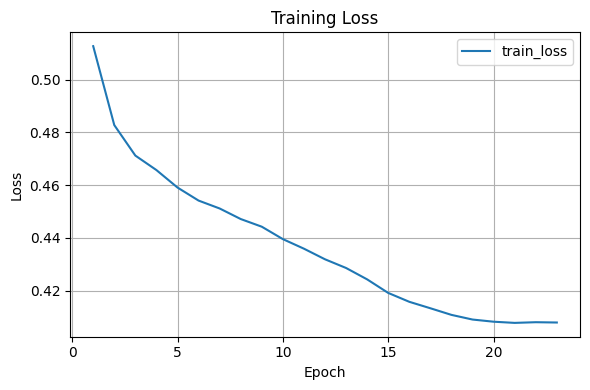

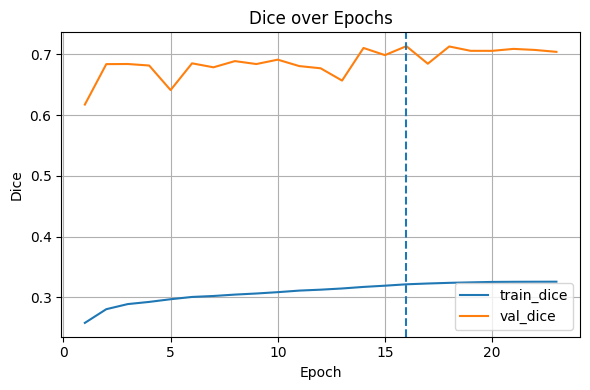

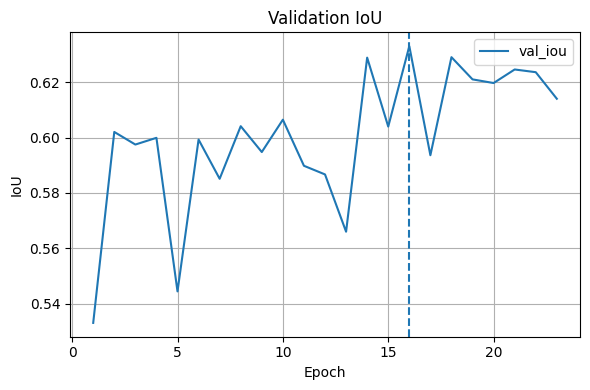

In [15]:
os.makedirs(os.path.join(OUT_DIR, "figs_train"), exist_ok=True)

# Loss
plt.figure(figsize=(6,4))
plt.plot(df["epoch"], df["train_loss"], label="train_loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Training Loss")
plt.grid(True); plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "figs_train", "curve_loss.png"), dpi=200)
plt.show()

# Dice
plt.figure(figsize=(6,4))
plt.plot(df["epoch"], df["train_dice"], label="train_dice")
plt.plot(df["epoch"], df["val_dice"],   label="val_dice")
plt.axvline(best_epoch, linestyle="--")  # highlight best epoch
plt.xlabel("Epoch"); plt.ylabel("Dice"); plt.title("Dice over Epochs")
plt.grid(True); plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "figs_train", "curve_dice.png"), dpi=200)
plt.show()

# IoU
plt.figure(figsize=(6,4))
plt.plot(df["epoch"], df["val_iou"], label="val_iou")
plt.axvline(best_epoch, linestyle="--")
plt.xlabel("Epoch"); plt.ylabel("IoU"); plt.title("Validation IoU")
plt.grid(True); plt.legend()
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "figs_train", "curve_iou.png"), dpi=200)
plt.show()